# NCI60 exploratory analysis

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem

In [39]:
# df = pd.read_csv("/Users/sethhowes/Downloads/DOSERESP.csv")

CONCENTRATION/RESPONSE DATA
- RELEASE_DATE The date of this data release.
- EXPID Please see the General Comments above.
- PREFIX The identifier of the sequence from which an NSC number was assigned. All public data are in the S series.
- NSC The numeric identifier in the S series.
- CONCENTRATION_UNIT Please see the General Comments above.
- LOG_HI_CONCENTRATION The log10 of the highest concentration of the concentration/response data.
- CONCENTRATION The log10 of the concentration in the dilution series.
- PANEL_NUMBER Internal identifier. The combinations of panel_number and cell_number are unique cell line identifiers.
- CELL_NUMBER Internal identifier. The combinations of panel_number and cell_number are unique cell line identifiers.
- PANEL_NAME The name of the NCI cell line panel (cancer type).
- CELL_NAME The name of the NCI cell line.
- PANEL_CODE An abbreviation for the panel_name.
- COUNT_GIPRCNT Count of GIPRCNT values.
- AVERAGE_GIPRCNT Average of GIPRCNT values.
- STDDEV_GIPRCNT Standard deviation of GIPRCNT values.
- COUNT_PTC Count of PTC values.
- AVERAGE_PTC Average of PTC values.
- STDDEV_PTC Standard deviation of PTC values.

From what I can understand from the following [NCI60 documentation](https://wiki.nci.nih.gov/display/NCIDTPdata/NCI-60+Growth+Inhibition+Data), the raw NCI60 dataset is interpolated to derive LC50, IC50, GI50, and TGI values. Each of these endpoints is in its own file. I will now check to see whether this raw information is processed into multiple target endpoints.

In [40]:
gi50_df = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/nci60/GI50.csv")
ic50_df = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/nci60/IC50.csv")
lc50_df = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/nci60/LC50.csv")
tgi_df = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/nci60/TGI.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
gi50_df.head()

In [ ]:
ic50_df.head()

In [ ]:
lc50_df.head()

In [ ]:
tgi_df.head()

In [ ]:
gi50_df.shape

In [ ]:
ic50_df.shape

In [ ]:
lc50_df.shape

In [ ]:
tgi_df.shape

It is clear that the 5 smaller dataframes are all derived from the original raw dataframe. As such, I will continue to create assays from the following 4 dataframes:
- lc50_df - the concentration of a drug that kills 50% of cells (<-50 GIPRCNT)
- gi50_df - the concentration of a drug that results in a 50% growth inhibition of a particular cell line (<50 GIRPRNT)
- tgi_df - the concentration of a drug to halt growth (<0 GIRPRCNT)
- ic50_df - the concentration at which a biological function is inhibited to 50% (<50 PCT)

I won't create assays from the original raw dataframe.

## Assay creation

All of the above dataframes have the same schema, so can be processed in the same way. Grouping by `PANEL_NAME` and `CELL_NAME` may be the best way to define an assay. `PANEL_NAME` refers to the type of cancer the cell line studies (e.g. colon cancer). `CELL_NAME` refers to the specific cell line being studied. Each cancer can include multiple cell lines. I will check the number of assays and assay sizes when grouped by these two columns.

In [55]:
assay_components = ["PANEL_NAME", "CELL_NAME"]
lc50_df.groupby(assay_components).size()

PANEL_NAME              CELL_NAME
Bone/Muscle             CHA-59          16
                        TE85             3
Breast Cancer           BT-549       51929
                        HS 578T      54867
                        MAXF 401       206
                                     ...  
Renal Cancer            UOK-57          17
Rhabdoid Tumor          A-204           16
Small Cell Lung Cancer  DMS 114      21496
                        DMS 273      19791
                        LXFS 650L       14
Length: 159, dtype: int64

Looking at the above, I would probably have the same assays if I just grouped by `CELL_NAME`. I will do a quick sense chekc to confirm whether this is true.

In [56]:
assays = lc50_df.groupby(["CELL_NAME"]).size()
len(assays)

159

In [57]:
assays["CHA-59"]

16

We can see that these groupings are identical.

I will now check to see how many assays have more than 24 and 32 members respectively.

In [58]:
print("Number of assays with > 24 observations: ", (assays > 24).sum())
print("Number of assays with > 32 observations: ", (assays > 24).sum())

Number of assays with > 24 observations:  110
Number of assays with > 32 observations:  110


I will now plot the distribution of assay sizes for this.

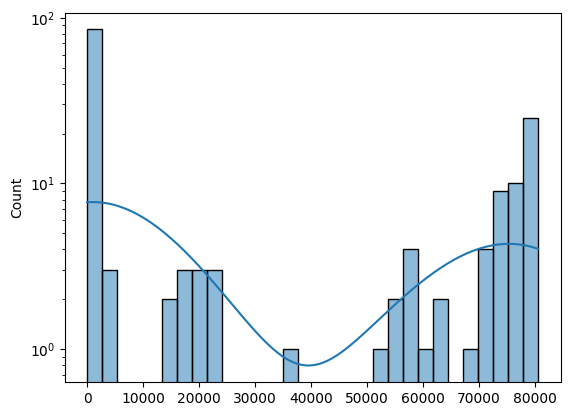

In [59]:
# Create the histogram
sns.histplot(assays, bins=30, kde=True)

# Set y-axis to logarithmic scale
plt.gca().set_yscale('log')

# Display the plot
plt.show()

There are quite a few assays with small numbers of observations, with a large proportion having large numbers of assays (in the 10,000s).

There are also some questions I need to address about the data:
- Do I need to normalise the data (i.e. are there different concentration units)?

In [60]:
lc50_df["CONCENTRATION_UNIT"].value_counts()

CONCENTRATION_UNIT
M    4562957
u      38140
V       2807
Name: count, dtype: int64

Each concentration unit is defined as follows:
- M
- u 
- V
The documentation refers to what each unit as follows:
> Most NSC numbers represent small molecules, and the reported concentrations use a "M" (molar) CONCENTRATION_UNIT.  For more complex biological agents concentrations may be reported as µg/ml (micrograms per milliliter) with a CONCENTRATION_UNIT "u".  Mixtures, extracts, crude fractions, etc.  in the assay may use units of µg/ml or volume-based measurements designated by CONCENTRATION_UNIT "V". (There is no further definition regarding what a volume-based concentration means.)

I therefore don't believe it's possible to convert between these different units. Instead of excluding all of these values from the dataset, I can try and group by this unit as well and see how this changes the composition of assays.

I can also group by the EXPID, to see if this gives sufficient assays above the threshold.

In [61]:
assay_components = ["PANEL_NAME", "CELL_NAME", "CONCENTRATION_UNIT", "EXPID"]
stringent_assays = lc50_df.groupby(assay_components).size().reset_index(name='count')

In [62]:
print("Number of assays with > 24 observations: ", (stringent_assays["count"] > 24).sum())
print("Number of assays with > 32 observations: ", (stringent_assays["count"] > 32).sum())

Number of assays with > 24 observations:  72934
Number of assays with > 32 observations:  45130


So when grouping by this concentration unit, and EXPID, we vastly increase the number of assays that we have.

In [63]:
stringent_assays[stringent_assays["count"] > 24].head(20)

PANEL_NAME CELL_NAME CONCENTRATION_UNIT     EXPID  count
6   Breast Cancer    BT-549                  M  0001MD05     25
9   Breast Cancer    BT-549                  M  0001MD10     44
15  Breast Cancer    BT-549                  M  0001NS07     29
24  Breast Cancer    BT-549                  M  0002MD11     26
34  Breast Cancer    BT-549                  M  0002NS14     29
46  Breast Cancer    BT-549                  M  0003MD26     46
47  Breast Cancer    BT-549                  M  0003MD27     36
48  Breast Cancer    BT-549                  M  0003MD28     29
55  Breast Cancer    BT-549                  M  0003NS27     34
59  Breast Cancer    BT-549                  M  0004MD29     31
60  Breast Cancer    BT-549                  M  0004MD31     31
62  Breast Cancer    BT-549                  M  0004MD33     32
63  Breast Cancer    BT-549                  M  0004MD34     47
64  Breast Cancer    BT-549                  M  0004MD35     30
69  Breast Cancer    BT-549                  M  0004NS31     32
72  Breast Cancer    BT-549                  M  0004NS34     39
73  Breast Cancer    BT-549                  M  0004NS35     46
74  Breast Cancer    BT-549                  M  0004NS36     26
78  Breast Cancer    BT-549                  M  0005MD39     37
84  Breast Cancer    BT-549                  M  0005MD46     30

Let's have a look at some of the outcomes values (`AVERAGE`) for one of the stringent assays.

In [64]:
selected_rows = lc50_df[
    (lc50_df['PANEL_NAME'] == 'Breast Cancer') &
    (lc50_df['CELL_NAME'] == 'BT-549') & 
    (lc50_df['CONCENTRATION_UNIT'] == 'M')
]
selected_rows

RELEASE_DATE     EXPID PREFIX     NSC CONCENTRATION_UNIT  \
28           20210223  0001MD05      S   19893                  M   
85           20210223  0001MD05      S  713750                  M   
108          20210223  0001MD05      S  713793                  M   
140          20210223  0001MD05      S  713829                  M   
309          20210223  0001MD05      S  713796                  M   
...               ...       ...    ...     ...                ...   
4603626      20230401  2010RS45      S  822752                  M   
4603667      20230401  2010RS45      S  823371                  M   
4603796      20230401  2301NS84      S  123127                  M   
4603853      20230401  2302NS97      S  836407                  M   
4603895      20230401  2302NS97      S  839865                  M   

         LOG_HI_CONCENTRATION  PANEL_NUMBER  CELL_NUMBER     PANEL_NAME  \
28                    -2.6021             5           13  Breast Cancer   
85                    -4.0000             5           13  Breast Cancer   
108                   -4.0000             5           13  Breast Cancer   
140                   -4.0000             5           13  Breast Cancer   
309                   -4.0000             5           13  Breast Cancer   
...                       ...           ...          ...            ...   
4603626               -4.0000             5           13  Breast Cancer   
4603667               -4.0000             5           13  Breast Cancer   
4603796               -4.6021             5           13  Breast Cancer   
4603853               -4.0000             5           13  Breast Cancer   
4603895               -4.0000             5           13  Breast Cancer   

        CELL_NAME PANEL_CODE  COUNT  AVERAGE  STDDEV  
28         BT-549        BRE      1  -2.6021     0.0  
85         BT-549        BRE      1  -4.0000     0.0  
108        BT-549        BRE      1  -4.2229     0.0  
140        BT-549        BRE      1  -4.0000     0.0  
309        BT-549        BRE      1  -4.0000     0.0  
...           ...        ...    ...      ...     ...  
4603626    BT-549        BRE      1  -4.0000     0.0  
4603667    BT-549        BRE      1  -4.3485     0.0  
4603796    BT-549        BRE      1  -5.6608     0.0  
4603853    BT-549        BRE      1  -4.2642     0.0  
4603895    BT-549        BRE      1  -4.0000     0.0  

[51570 rows x 14 columns]

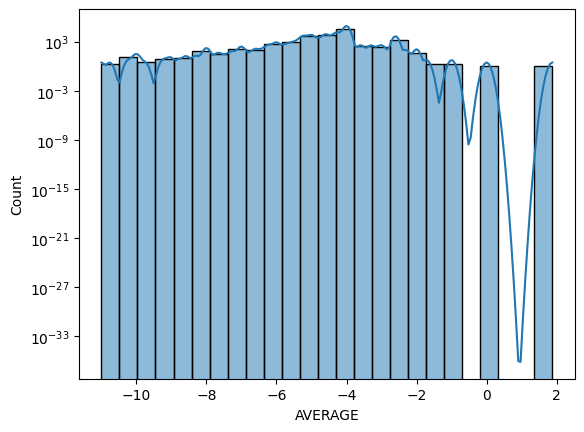

In [65]:
# Create the histogram
sns.histplot(selected_rows["AVERAGE"], bins=25, kde=True)

# Set y-axis to logarithmic scale
plt.gca().set_yscale('log')

plt.show()

We see here that the large values of AVERAGE are less frequent. This is possible because these values are spurious. It is likely that concentrations this small were not tested.

In [ ]:
# Create the histogram
sns.histplot(stringent_assays['count'], bins=30, kde=True)

# Set y-axis to logarithmic scale
plt.gca().set_yscale('log')

# Display the plot
plt.show()

Distributions of assay counts looks good.

Let's see what happens when we throw out:
1) values with value > -4
2) values which belong to an assays with a size less than 24

In [77]:
len(lc50_df)

4603904

In [78]:
# Remove values with higher than -4.5 AVERAGE conc
assay_df = lc50_df[lc50_df["AVERAGE"] < 3.5]

In [79]:
len(assay_df)

4603554

In [80]:
# Remove records that belong to a group of greater than 24 members
assay_df = assay_df.groupby(assay_components).filter(lambda x: len(x) >= 24)

In [81]:
len(assay_df)

2882154

Now let's also have a look at, and then remove those assays with an outcomes that spans less than one order of mangitude.

In [82]:
# Now, perform the min, max and difference calculations on the filtered DataFrame
assays = assay_df.groupby(assay_components)['AVERAGE'].agg(['min', 'max', 'count']).reset_index()
assays['min_max_diff'] = assays['max'] - assays['min']

In [83]:
(assays['min_max_diff'] > 2).sum()

36287

In [84]:
(assays['min_max_diff'] > 1).sum()

62357

In [85]:
(assays['min_max_diff'] > 0.5).sum()

67830

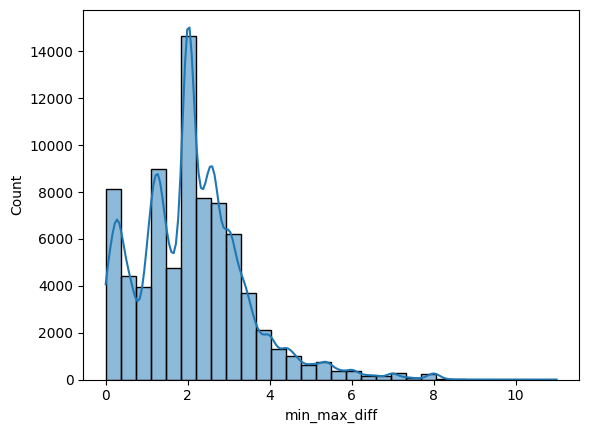

In [86]:
# Create the histogram
sns.histplot(assays['min_max_diff'], bins=30, kde=True)

# Display the plot
plt.show()

In [87]:
len(assay_df)

2882154

In [88]:
# Get records where the order of magnitude range of the assay outcomes is greater than 2 
assay_df = assay_df.groupby(assay_components).filter(lambda x: (max(x['AVERAGE']) - min(x['AVERAGE'])) >= 2)

In [89]:
len(assay_df)

1768523

## Mapping NSC numbers to SMILES

In [90]:
# Define the column names
column_names = ["nsc", "casrn", "smiles"]

# Read the text file
identifiers = pd.read_csv('/Users/sethhowes/Desktop/FS-Tox/data/external/NCIOPENB_SMI.txt', delim_whitespace=True, names=column_names)

In [91]:
identifiers

nsc     casrn                                             smiles
0            1  553-97-9                                  CC1=CC(=O)C=CC1=O
1            2  120-78-5                   S(SC1=Nc2ccccc2S1)C3=Nc4ccccc4S3
2            3  946-31-6          [N+](=O)([O-])c1cc(cc(Cl)c1O)[N+](=O)[O-]
3            4  121-66-4                         [N+](=O)([O-])C1=CNC(=N)S1
4            5  117-79-3                      O=C1c2ccccc2C(=O)c3ccc(N)cc13
...        ...       ...                                                ...
237766  679243  999-99-9            S1C(Br)=CC=C1C=C2NC(=S)N(CN3CCCCC3)C2=O
237767  679244  999-99-9  S1C(Br)=CC=C1C=C2N=C(SC3OC(COC(=O)C)C(OC(=O)C)...
237768  679245  999-99-9  S1C(Br)=CC=C1C=C2N=C(SC3OC(COC(=O)C)C(OC(=O)C)...
237769  679246  999-99-9  S1C(Br)=CC=C1C=C2N=C(SC3OC(COC(=O)C)C(OC(=O)C)...
237770  679247  999-99-9  S1C(=CC2=C1Sc3ccccc3C2=O)C=C4N=C(SC5OC(COC(=O)...

[237771 rows x 3 columns]

In [92]:
assay_df = pd.merge(assay_df, identifiers, left_on="NSC", right_on="nsc", how="inner")

In [93]:
len(assay_df)

1009778

In [94]:
 # Convert smiles to canonical smiles
mol_objects = assay_df["smiles"].apply(Chem.MolFromSmiles)
assay_df["canonical_smiles"] = mol_objects.apply(
    lambda x: Chem.MolToSmiles(x) if x is not None else None
)

[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom # 34 B, 4, is greater than permitted
[13:37:25] Explicit valence for atom #

[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 1 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom #

[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:26] Explicit valence for atom # 6 N, 4, is g

[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:26] Explicit valence for atom #

[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 7 N, 4, is g

[13:37:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 10 11 12 13 14 15 16 17 18 20
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 10 11 12 13 14 15 16 17 18 20
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 10 11 12 13 14 15 16 17 18 20
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 10 11 12 13 14 15 16 17 18 20
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 10 11 12 13 14 15 16 17 18 20
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 10 11 12 13 14 15 16 17 18 20
[13:37:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 

[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:37:27] Explicit valence for atom # 1 N, 4, is g

[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[13:37:28] Explicit valence for atom # 9 O, 3, is g

[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
[13:37:28] Can't kekulize mol.  Unkekuli

[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom # 7 Sn, 6, is greater than permitted
[13:37:28] Explicit valence for atom #

[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 9 N, 4, is g

[13:37:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11 12 13 15 16
[13:37:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11 12 13 15 16
[13:37:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11 12 13 15 16
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:29] 

[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:29] Explicit valence for atom #

[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:37:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 1

[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:37:30] Explicit valence for atom #

[13:37:31] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 10 11 12 13 14 15 16 17 18 22 23 24 25
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 10 11 12 13 14 15 16 17 18 22 23 24 25
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 16 17 18 19 20 21 23 24
[13:37:31] Can't kek

[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[13:37

[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 18 21 22 23 26 27 28 29
[13:37:36]

[13:37:36] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:36] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 16 17 18 20 23 24 25
[13:37:37] Can't kekulize mol.

[13:37:38] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 31 N, 4, is greater than permitted
[13:37:38] Explicit valence for atom # 31 N,

[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23
[13:37:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 11 12 13 14 17 20 21 22 23

[13:37:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 9 10 11 12 13 14 15 16 17 18 19
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 9 10 11 12 13 14 15 16 17 18 19
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12 13 15 16
[13:37:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 12

[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 28 29 30 32 33 34
[13:37:44]

[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 15 16
[13:37:44] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:37:44] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:37:44] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:37:44] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:37:44] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:37:44] Explicit valence for atom # 0 B, 4, is grea

[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16 17 54 55 56 57 58
[13:37:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 1

[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:47] Explicit valence for atom #

[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 11 14 15 16 17 20 21 22
[13:37:49] Can't keku

[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 24 25 26 27 29 30
[13:37:49] Can't kekulize mol.  Unkekuli

[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:37:50] Explicit valence for atom #

[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:37:51] Explicit valence for atom # 7 N, 4, is g

[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 8 9 10 11 12 13 17 18
[13:

[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 27 29 30 31
[13:37:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 25 26 

[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 19 20 21 22 23 24 25 26 28 29
[13:37:52] Can't kekulize mol.  Unkekuli

[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 11 12 14 15 16 17
[13:37:52] Can't kekulize mol.  Unkekulized

[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:52] Explicit valence for atom # 4 N, 4, is g

[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:37:54] Explicit valence for atom #

[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 2 O, 3, is g

[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 7 8
[13:37:55] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:55] Explicit valence for atom # 3 O, 3, is greater than permitted


[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:37:55] Explicit valence for atom #

[13:37:56] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[13:37:56] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:37:56] Explicit valence for atom # 2 O, 3, is greater than 

[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 6 N, 4, is g

[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:37:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 11 12
[13:37:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 11 12
[13:37:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 11 12
[13:37:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 11 12
[13:37:5

[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 5 N, 4, is g

[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:57] Explicit valence for atom #

[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:57] Explicit valence for atom # 2 N, 4, is g

[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[13:37:58] Explicit valence for atom #

[13:37:58] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14
[13:37:58] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:58] Explicit valence for at

[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:37:58] Explicit valence for atom #

[13:37:59] Explicit valence for atom # 37 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 37 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:37:59] Can't kekulize mol.  Unkekulized atoms: 6 7 8 11 12
[13:37:59] Can't kekulize mol.  Unkekulized atoms: 6 7 8 11 12
[13:37:59] Explicit valence for atom # 0 Sn, 6, is greater than permitted
[13:37:59] Explicit valence for atom # 32 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 32 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 4 N, 4, is greater than per

[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is g

[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:37:59] Explicit valence for atom # 5 N, 4, is g

[13:38:00] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 5 N, 4, i

[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:00] Explicit valence for atom # 6 N, 4, is g

[13:38:00] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:00] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 31 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 31 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 31 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 31 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 31 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 39 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 39 N, 

[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[13:38:01] Can't kekuliz

[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:01] Explicit valence for atom # 9 N, 4, is g

[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 4 N, 4, is g

[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:02] Explicit valence for atom # 0 N, 4, is g

[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:02] Explicit valence for atom # 3 O, 3, is g

[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom #

[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[13:38:03] Can't kek

[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom #

[13:38:03] Explicit valence for atom # 7 O, 3, is greater than permitted
[13:38:03] Explicit valence for atom # 7 O, 3, is greater than permitted
[13:38:03] Explicit valence for atom # 7 O, 3, is greater than permitted
[13:38:03] Explicit valence for atom # 7 O, 3, is greater than permitted
[13:38:03] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:03] Explicit valence for atom # 8 N, 4, is g

[13:38:04] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:38:04] Explicit valence for atom # 1 O, 3, is g

[13:38:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:04] Explicit valence for atom #

[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:38:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 1

[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is g

[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:05] Explicit valence for atom # 5 N, 4, is g

[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 10 11
[13:38

[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 5 N, 4, is g

[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom # 0 Tl, 4, is greater than permitted
[13:38:06] Explicit valence for atom #

[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:06] Explicit valence for atom # 2 O, 3, is g

[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 15 N, 4, is

[13:38:07] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom #

[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:07] Explicit valence for atom # 3 N, 4, is g

[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[13:38:08] Explicit valence for atom # 5 O, 3, is g

[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom #

[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:08] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24 25 26
[13:38:08] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24 25 26
[13:38:08] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24 25 26


[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:38:09] Explicit valence for atom #

[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 20 22 23 24
[13:38:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 14 15 18 19 

[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:10] Explicit valence for atom #

[13:38:10] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 13 for input: '[Ti]1236(Cl)(Oc4cccc5cccn1c45)(O2c7cccc8cccn36c78)Oc9cccc%10cccnc9%10.Cl'
[13:38:10] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 13 for input: '[Ti]1236(Cl)(Oc4cccc5cccn1c45)(O2c7cccc8cccn36c78)Oc9cccc%10cccnc9%10.Cl'
[13:38:10] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 13 for input: '[Ti]1236(Cl)(Oc4cccc5cccn1c45)(O2c7cccc8cccn36c78)Oc9cccc%10cccnc9%10.Cl'
[13:38:10] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 13 for input: '[Ti]1236(Cl)(Oc4cccc5cccn1c45)(O2c7cccc8cccn36c78)Oc9cccc%10cccnc9%10.Cl'
[13:38:10] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 13 for input: '[Ti]1236(Cl)(Oc4cccc5cccn1c45)(O2c7cccc8cccn36c78)Oc9cccc%10cccnc9%10.Cl'
[13:38:10] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 13 for input: '[Ti]1236(Cl)(Oc4cccc5ccc

[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom # 21 O, 3, is greater than permitted
[13:38:11] Explicit valence for atom #

[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom #

[13:38:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14 15 16 17 21 22 23 24
[13:38:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14 15 16 17 21 22 23 24
[13:38:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14 15 16 17 21 22 23 24
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:11] Explicit valence for atom # 10 N

[13:38:12] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 7 N, 4

[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:12] Explicit valence for atom # 1 N, 4, is g

[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:13] Explicit valence for atom # 7 N, 4, is g

[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 2 O, 3, is g

[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:14] Explicit valence for atom # 0 N, 4, is g

[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:38:14] Explicit valence for atom # 4 O, 3, is g

[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 4 N, 4, is g

[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:15] Explicit valence for atom # 0 N, 4, is g

[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13 14 15
[13:38:16] Can't kekulize

[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom #

[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom # 10 N, 4, is greater than permitted
[13:38:17] Explicit valence for atom #

[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:18] Explicit valence for atom # 6 N, 4, is g

[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom #

[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[13:38:19] Explicit valence for atom #

[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19] Can't kekulize mol.  Unkekulized atoms: 10 11 15 16 17
[13:38:19]

[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:20] Explicit valence for atom # 1 N, 4, is g

[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 21 23 24 25
[13:38:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 14 15 16 19 20 

[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:21] Explicit valence for atom #

[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 3 N, 4, is g

[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 24 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[13:38:22] Explicit valence for atom #

[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[13:38:23] Explicit valence for atom # 3 N, 4, is greater than permitted
[13

[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:23] Explicit valence for atom #

[13:38:24] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 0 B, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 4 B, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:24] Explicit valence for atom # 9 N, 4, is g

[13:38:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 18 N

[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:26] Explicit valence for atom #

[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:27] Explicit valence for atom # 6 N, 4, is g

[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:28] Explicit valence for atom #

[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:29] Explicit valence for atom # 8 N, 4, is g

[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:30] Explicit valence for atom # 6 N, 4, is g

[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:31] Explicit valence for atom #

[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:33] Explicit valence for atom #

[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom # 55 B, 4, is greater than permitted
[13:38:35] Explicit valence for atom #

[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:36] Explicit valence for atom #

[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 21 22 23 24 25 26
[13:38:36] Can't kekulize mol.  Unkekulized atoms: 0

[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom #

[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:37] Explicit valence for atom #

[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is g

[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 24 25 26
[13:38:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 24 25 26
[13:38:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 24 25 26
[13:38:38] Can't kekulize mol.  Unkekulized atoms: 0 1

[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom #

[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:39] Explicit valence for atom # 7 N, 4, is g

[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 19 22 25 26
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 10 13 14 15 16 17 18 

[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[13:38:40]

[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom #

[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom # 48 N, 4, is greater than permitted
[13:38:41] Explicit valence for atom #

[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 27 30 31
[13:38:42] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 2

[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom #

[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:42] Explicit valence for atom #

[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 17 18 19 20 21
[13:38:43] Can't kekulize mol.  Unkekulized atoms: 11 13 14 16 1

[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[13:38:43] Explicit valence for atom # 4 N, 4, is g

[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom #

[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom #

[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:44] Explicit valence for atom #

[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom #

[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom #

[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:45] Explicit valence for atom #

[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[13:38:46] Explicit valence for atom #

[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:47] Explicit valence for atom # 5 N, 4, is g

[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 19 20 21 22
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 14 15 16 17 18 

[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32 33 34 35
[13:38:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 22 27 28 29 32

[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 11 12 13 14 15 17 18 19 21 24 25 26
[13:38:48] Can't kekulize mol.

[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:38:48] Explicit valence for atom # 1 N, 4, is g

[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 9 N, 4, is g

[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom #

[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:49] Explicit valence for atom #

[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:38:50] Can't kekulize

[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 3 N, 4, is g

[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:50] Explicit valence for atom # 7 N, 4, is g

[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom #

[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom #

[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[13:38:51] Explicit valence for atom #

[13:38:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9 11 12 13 14 15 16 17 18
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9 11 12 13 14 15 16 17 18
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9 11 12 13 14 15 16 17 18
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9 11 12 13 14 15 16 17 18
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9 11 12 13 14 15 16 17 18
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9 11 12 13 14 15 16 17 18
[13:38:52] Can't kekulize mol.  Unkekulized atoms: 3

[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:38:52] Explicit valence for atom #

[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[13:38:52] Explicit valen

[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 5 N, 4, is g

[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 0 N, 4, is g

[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:53] Explicit valence for atom # 6 N, 4, is g

[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 25 26 28 29 30
[13:38:54] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 2

[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom #

[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom #

[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:54] Explicit valence for atom # 7 N, 4, is g

[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:55] Explicit valence for atom # 3 N, 4, is g

[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:38:55] Can't kekulize mol.  Unkekuli

[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30 32 33 41 42
[13:38:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30 32 33 41 42
[13:38:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30 32 33 41 42
[13:38:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30 32 33 41 42
[13:38:56] Can't kekulize mol.  Unkekulized atoms: 22 23

[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 7 N, 4, is g

[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[13:38:56] Explicit valence for atom # 3 N, 4, is g

[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 13 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom #

[13:38:57] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 6 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 4 B, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 4 B, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 4 B, 4, is greater than permitted
[13:38:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 13 14 15 16 17 18 19 20 21 22 23
[13:38:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14 15 16 17 21 22 23 24
[13:38:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14 15 16 17 21 22 23 24
[13:38:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14 15 16 17 21 22 23 24
[13:38:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:38:57] Explicit valence for atom # 10 O, 3, is greater than permitted
[13:38:57] Explicit valence for atom # 10 O, 3, is greater than permitted
[13:38:57] Explicit vale

In [50]:
assay_df.dropna(subset=["canonical_smiles"], inplace=True)
len(assay_df)

962673

I now need to repeat the filtering of observations belonging to group size > 24 due to removing rows in the canonical_smiles step.

In [99]:
# Get records that belong to a group of greater than 24 members
assay_df = assay_df.groupby(assay_components).filter(lambda x: len(x) >= 24)

In [106]:
len(assay_df)

889813

One final sense check to ensure that I am only including rows belonging to groups with greater than 24 members.

In [101]:
final_assay_check = assay_df.groupby(assay_components).size().reset_index(name='count')

In [104]:
len(final_assay_check)

22899

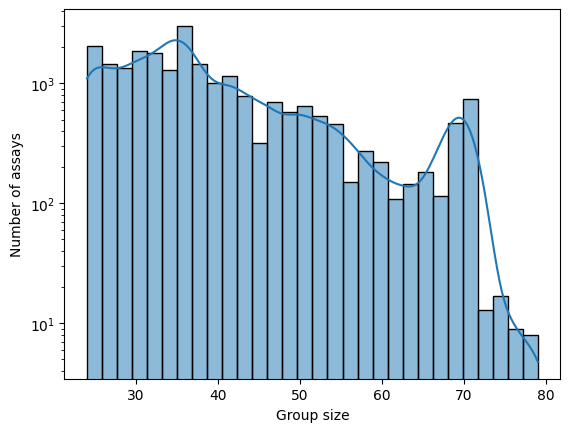

In [105]:
# Create the histogram
sns.histplot(final_assay_check['count'], bins=30, kde=True)

# Set y-axis to logarithmic scale
plt.gca().set_yscale('log')

# Label x- and y-axes
plt.xlabel('Group size')
plt.ylabel('Number of assays')

# Display the plot
plt.show()